In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from imblearn.over_sampling import RandomOverSampler
from sklearn.preprocessing import StandardScaler
import copy
import seaborn as sns
import tensorflow as tf
from sklearn.linear_model import LinearRegression

# Dataset:
Dua, D. and Graff, C. (2019). UCI Machine Learning Repository [http://archive.ics.uci.edu/ml]. Irvine, CA: University of California, School of Information and Computer Science.

Source: Data Source :http://data.seoul.go.kr/ SOUTH KOREA PUBLIC HOLIDAYS. URL: publicholidays.go.kr

In [ ]:
dataset_cols = ["bike_count", "hour", "temp", "humidity", "wind", "visibility", "dew_pt_temp", "radiation", "rain", "snow", "functional"]

# Use the gdrive
from google.colab import drive
drive.mount('/content/drive')

# Reading the source file
df = pd.read_csv('/content/drive/My Drive/Colab try - Regression/SeoulBikeData.csv', encoding='unicode escape')
df = df.drop(["Date", "Holiday", "Seasons"], axis=1)

# Modifications
df.columns = dataset_cols
df["functional"] = (df["functional"] == "Yes").astype(int)
df = df[df["hour"] == 12]
df = df.drop(["hour"], axis=1)

df

Mounted at /content/drive


,bike_count,temp,humidity,wind,visibility,dew_pt_temp,radiation,rain,snow,functional
12,449,1.7,23,1.4,2000,-17.2,1.11,0.0,0.0,1
36,479,4.3,41,1.3,1666,-7.8,1.09,0.0,0.0,1
60,333,5.8,85,1.7,349,3.4,0.43,0.0,0.0,1
84,393,-0.3,38,4.8,1823,-12.9,1.11,0.0,0.0,1
108,321,-2.3,25,0.0,1962,-19.7,0.00,0.0,0.0,1
...,...,...,...,...,...,...,...,...,...,...
8652,752,9.1,57,1.1,562,1.0,1.69,0.0,0.0,1
8676,672,9.3,61,1.5,390,2.1,0.85,0.0,0.0,1
8700,635,7.9,14,1.7,1688,-18.0,1.81,0.0,0.0,1
8724,661,5.6,27,0.3,1522,-11.9,0.34,0.0,0.0,1


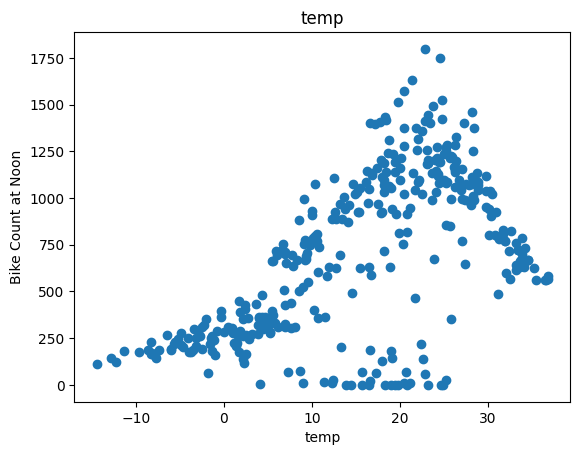

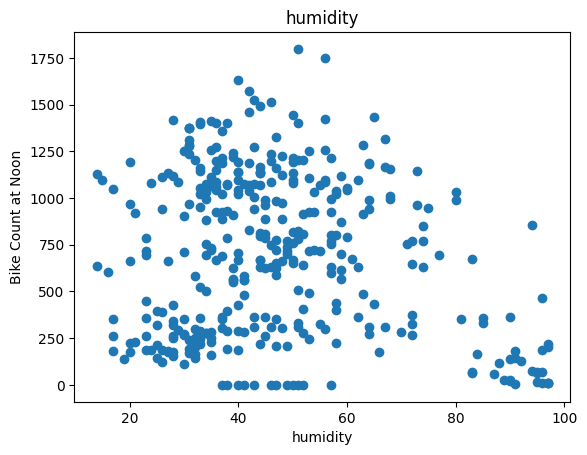

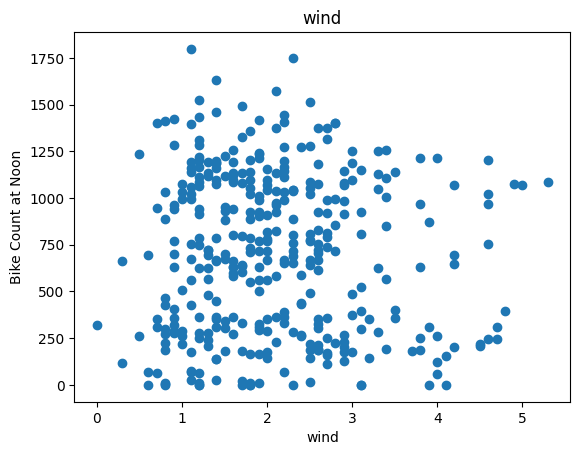

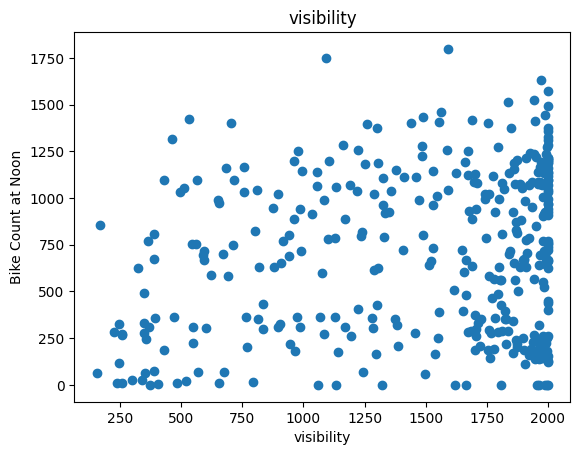

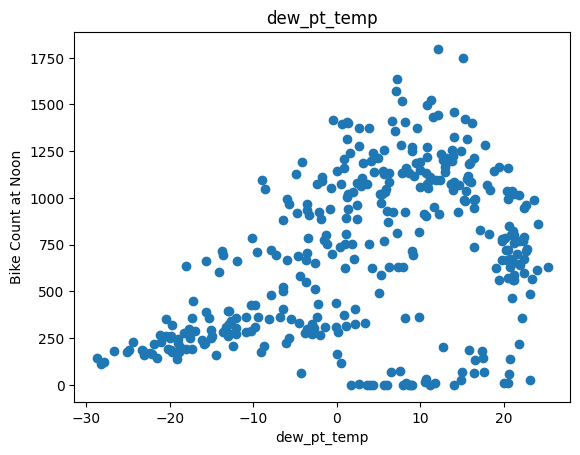

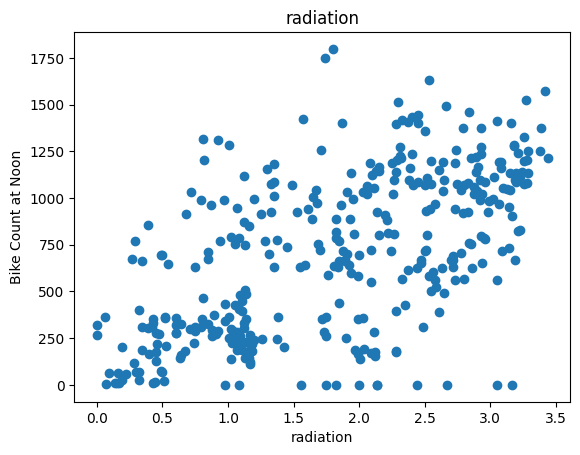

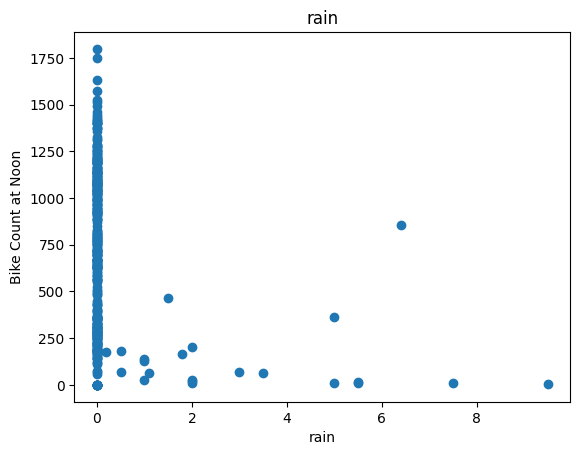

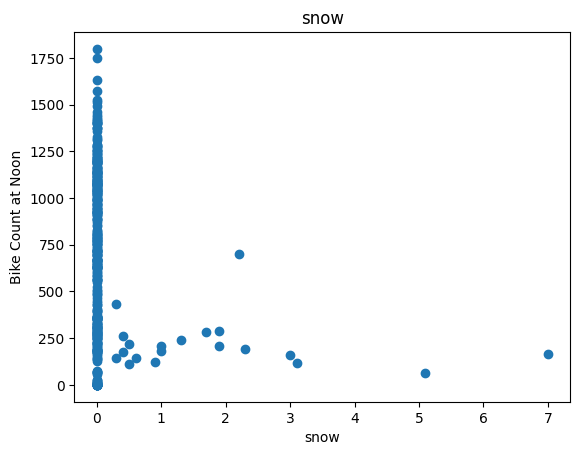

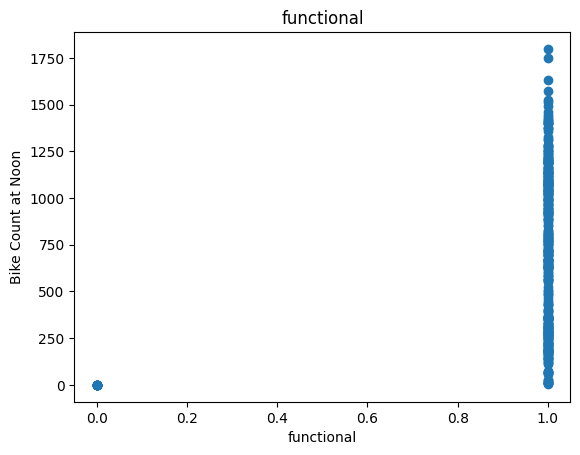

In [ ]:
# Previewing the scatter plot for every features corresponding to the no. of bikes
for label in df.columns[1:]:
  plt.scatter(df[label], df['bike_count'])
  plt.title(label)
  plt.ylabel("Bike Count at Noon")
  plt.xlabel(label)
  plt.show()

In [ ]:
df.drop(['wind','visibility','functional'], axis=1)
df

,bike_count,temp,humidity,wind,visibility,dew_pt_temp,radiation,rain,snow,functional
12,449,1.7,23,1.4,2000,-17.2,1.11,0.0,0.0,1
36,479,4.3,41,1.3,1666,-7.8,1.09,0.0,0.0,1
60,333,5.8,85,1.7,349,3.4,0.43,0.0,0.0,1
84,393,-0.3,38,4.8,1823,-12.9,1.11,0.0,0.0,1
108,321,-2.3,25,0.0,1962,-19.7,0.00,0.0,0.0,1
...,...,...,...,...,...,...,...,...,...,...
8652,752,9.1,57,1.1,562,1.0,1.69,0.0,0.0,1
8676,672,9.3,61,1.5,390,2.1,0.85,0.0,0.0,1
8700,635,7.9,14,1.7,1688,-18.0,1.81,0.0,0.0,1
8724,661,5.6,27,0.3,1522,-11.9,0.34,0.0,0.0,1


# Train, valid, and Test Dataset

In [ ]:
def get_xy(dataframe, y_label, x_labels):

    dataframe = copy.deepcopy(dataframe)

    # If no x_labels are provided, use all columns except y_label as features
    if x_labels is None or len(x_labels) == 0:
        X = dataframe[[c for c in dataframe.columns if c != y_label]].values
    else:
        # If only one column is provided in x_labels, reshape it to 2D
        if len(x_labels) == 1:
            X = dataframe[x_labels[0]].values.reshape(-1, 1)
        else:
            X = dataframe[x_labels].values

    # Extract the target/label column and reshape it to 2D
    y = dataframe[y_label].values.reshape(-1, 1)

    # Combine features and labels into a single dataset
    data = np.hstack((X, y))

    return data, X, y

### **What the get_xy() Function Does**
The function **`get_xy`** extracts the features (`X`) and labels (`y`) from a given DataFrame. It can:
1. Select specific columns as features (`x_labels`).
2. Use all columns except one (`y_label`) as features.
3. Return a combined dataset of features and labels.

In [ ]:
# Train Valid Test Dataset here
train, valid, test = np.split(df.sample(frac=1), [int(0.6*len(df)), int(0.8*len(df))])

# Let's use the temperature data as it's visually more correlated to the bike count
_, X_train_temp, y_train_temp = get_xy(train, "bike_count", x_labels=['temp'])
_, X_valid_temp, y_valid_temp = get_xy(valid, "bike_count", x_labels=['temp'])
_, X_test_temp, y_test_temp = get_xy(test, "bike_count", x_labels=['temp'])

/usr/local/lib/python3.11/dist-packages/numpy/core/fromnumeric.py:59: FutureWarning: 'DataFrame.swapaxes' is deprecated and will be removed in a future version. Please use 'DataFrame.transpose' instead.
  return bound(*args, **kwds)


# Applying Linear Regression

In [ ]:
temp_reg = LinearRegression()
temp_reg.fit(X_train_temp, y_train_temp)

print("Coefficient: ", temp_reg.coef_)
print("Intercept: ", temp_reg.intercept_)
print("Score: ", temp_reg.score(X_test_temp, y_test_temp))

Coefficient:  [[20.79370621]]
Intercept:  [370.30740936]
Score:  0.40355834727983686


## Definitions Breakdown
### **1. Coefficient (`temp_reg.coef_`)**
- The **coefficient** represents how much the target variable (`y`) changes when the corresponding feature (`X`) changes by 1 unit, assuming all other features stay the same.
- **Mathematical Formula**:  
  In a simple linear regression:
  
  <div class="math">
  \begin{equation}
  y = m \cdot x + b
  \end{equation}
  </div>
  
  1. \( m \): The **coefficient**, showing the "slope" of the line.
  2. \( x \): The input feature (independent variable).
  3. \( y \): The predicted value (dependent variable).

  For multiple features:
  <div class="math">
  \begin{equation}
  y = m_1 \cdot x_1 + m_2 \cdot x_2 + \dots + m_n \cdot x_n + b
  \end{equation}
  </div>
  - \( m_1, m_2, \dots, m_n \): Coefficients for each feature.
  - \( x_1, x_2, \dots, x_n \): Feature values.

- The coefficient tells you how steeply the line tilts for each input feature. A large coefficient means the feature has a big influence on the outcome.

---

### **2. Intercept (`temp_reg.intercept_`)**
- The **intercept** is the value of the target variable (`y`) when all features (`X`) are 0. It's where the line crosses the y-axis in the graph.
- **Mathematical Formula**:  
  In a simple linear regression:

  <div class="math">
  \begin{equation}
  b = y - m \cdot x
  \end{equation}
  </div>

  - \( b \): The intercept.

  For multiple features:
  <div class="math">
  \begin{equation}
  b = y - (m_1 \cdot x_1 + m_2 \cdot x_2 + \dots + m_n \cdot x_n)
  \end{equation}
  </div>

- Think of the intercept as the "starting point" of the line. It tells you the predicted value of \( y \) when there is no input (all \( x \) values are zero).

---

### **3. Score (`temp_reg.score(X_test_temp, y_test_temp)`)**
- The **score** measures how well the model's predictions match the actual data. In linear regression, this is called the **R-squared score** (\( R^2 \)).
- **Mathematical Formula**:

  <div class="math">
  \begin{equation}
  R^2 = 1 - \frac{\text{Sum of Squared Errors (SSE)}}{\text{Total Sum of Squares (TSS)}}
  \end{equation}
  </div>

  - \( SSE \): The difference between predicted and actual values squared and summed.
  - \( TSS \): The variation in the actual data.
  - \( R^2 \) ranges from 0 to 1, where:
    - 1 means perfect predictions.
    - 0 means the model predicts nothing better than guessing the average.

- The score is like a test grade for your model. If the score is close to 1, your model is doing great. If it's close to 0, your model isn't learning much from the data.

## Plotting the Regression

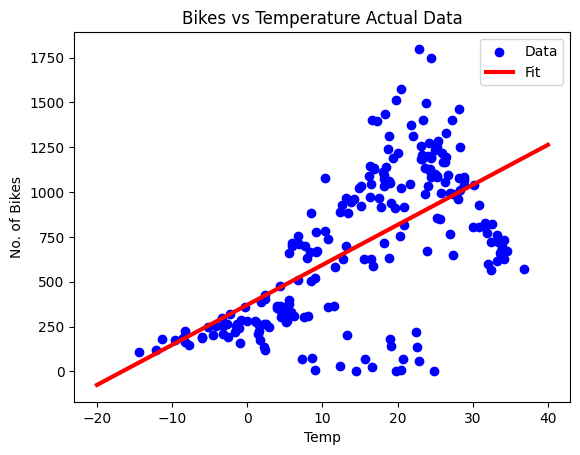

In [ ]:
# Actual Temperature vs Bikes Scatter plot
plt.scatter(X_train_temp, y_train_temp, label = 'Data', color = 'blue')

x = np.linspace(-20,40,100)
y_pred = temp_reg.predict(np.array(x).reshape(-1, 1))

# Plotting the line of best fit
plt.plot(x, y_pred, label = 'Fit', color = 'red', linewidth = 3)
plt.legend()
plt.title("Bikes vs Temperature Actual Data")
plt.ylabel("No. of Bikes")
plt.xlabel("Temp")
plt.show()

# Multiple Regression

In [ ]:
train, valid, test = np.split(df.sample(frac=1), [int(0.6*len(df)), int(0.8*len(df))])

# Using all features available
_, X_train_all, y_train_all = get_xy(train, "bike_count", x_labels = df.columns[1:])
_, X_valid_all, y_valid_all = get_xy(valid, "bike_count", x_labels= df.columns[1:])
_, X_test_all, y_test_all = get_xy(test, "bike_count", x_labels= df.columns[1:])

# Applying Linear Regression
all_reg = LinearRegression()
all_reg.fit(X_train_all, y_train_all)

print("Coefficient: ", all_reg.coef_)
print("Intercept: ", all_reg.intercept_)
print("Score: ", all_reg.score(X_test_all, y_test_all))

Coefficient:  [[-9.98149395e+00 -1.13478887e+01 -1.03783852e+01 -1.97235957e-03
   3.05567576e+01  1.07536568e+02 -4.03713063e+01 -9.23857086e+00
   8.18260616e+02]]
Intercept:  [331.45202179]
Score:  0.6348468428561027


/usr/local/lib/python3.11/dist-packages/numpy/core/fromnumeric.py:59: FutureWarning: 'DataFrame.swapaxes' is deprecated and will be removed in a future version. Please use 'DataFrame.transpose' instead.
  return bound(*args, **kwds)


# Linear Regression with Neural Network

In [ ]:
# Normalizing
temp_normalized = tf.keras.layers.Normalization(input_shape=(1,), axis=None)
temp_normalized.adapt(X_train_temp.reshape(-1))

# Create the nn_model
nn_model = tf.keras.Sequential([
    temp_normalized,
    tf.keras.layers.Dense(1)
])

# Compile the nn_model
nn_model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.1), loss='mean_squared_error')

# Apply the nn_model
history = nn_model.fit(
    X_train_temp.reshape(-1), y_train_temp,
    epochs=1000,
    validation_data = (X_valid_temp, y_valid_temp)
)

# Open hidden output to see the epochs

Epoch 1/1000
7/7 ━━━━━━━━━━━━━━━━━━━━ 1s 28ms/step - loss: 629973.0000 - val_loss: 635291.1875
Epoch 2/1000
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 610230.0625 - val_loss: 634000.0000
Epoch 3/1000
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 622168.3750 - val_loss: 632696.8750
Epoch 4/1000
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 660859.6875 - val_loss: 631397.5625
Epoch 5/1000
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 677634.3750 - val_loss: 630120.9375
Epoch 6/1000
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 674361.0000 - val_loss: 628826.5000
Epoch 7/1000
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 684383.5625 - val_loss: 627547.6875
Epoch 8/1000
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 644761.2500 - val_loss: 626289.4375
Epoch 9/1000
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 652867.6250 - val_loss: 625025.1250
Epoch 10/1000
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 613187.2500 - val_loss: 623769.5625
Epoch 11/1000
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss:

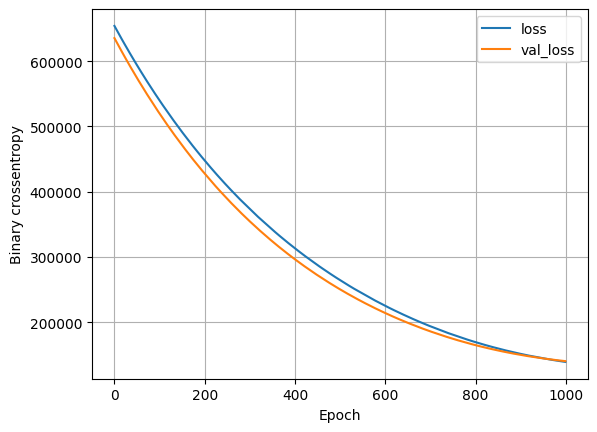

In [ ]:
# Defining The Loss Plot
def plot_loss(history):
  plt.plot(history.history['loss'], label='loss')
  plt.plot(history.history['val_loss'], label='val_loss')
  plt.xlabel('Epoch')
  plt.ylabel('Binary crossentropy')
  plt.legend()
  plt.grid(True)
  plt.show()

plot_loss(history)

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step 


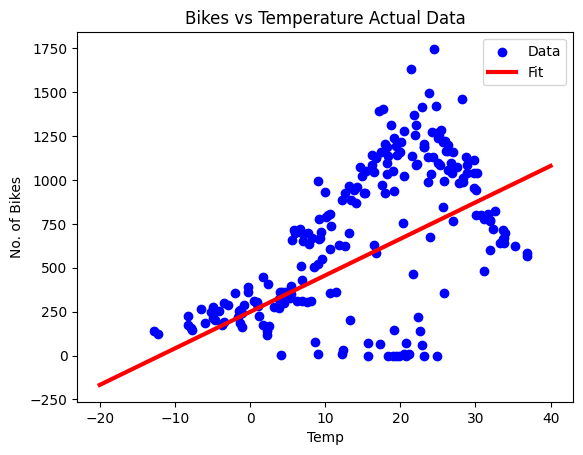

In [ ]:
# Actual Temperature vs Bikes Scatter plot
plt.scatter(X_train_temp, y_train_temp, label = 'Data', color = 'blue')

x = np.linspace(-20,40,100)
y_pred = nn_model.predict(np.array(x).reshape(-1, 1))

# Plotting the line of best fit
plt.plot(x, y_pred, label = 'Fit', color = 'red', linewidth = 3)
plt.legend()
plt.title("Bikes vs Temperature Actual Data")
plt.ylabel("No. of Bikes")
plt.xlabel("Temp")
plt.show()

# Multiple Regression with Neural Network

In [ ]:
# Normalizing
all_normalized = tf.keras.layers.Normalization(input_shape=(9,), axis=-1)
all_normalized.adapt(X_train_all)

# Create the nn_model
nn_model = tf.keras.Sequential([
    all_normalized,
    tf.keras.layers.Dense(32, activation='relu'),
    tf.keras.layers.Dense(32, activation='relu'),
    tf.keras.layers.Dense(1)
])

# Compile the nn_model
nn_model.compile( optimizer=tf.keras.optimizers.Adam(learning_rate=0.001), loss='mean_squared_error')

# Apply the nn_model
history = nn_model.fit(
    X_train_all, y_train_all,
    epochs=100,
    validation_data = (X_valid_all, y_valid_all)
)

# Open hidden output to see the epochs

Epoch 1/100


/usr/local/lib/python3.11/dist-packages/keras/src/layers/preprocessing/tf_data_layer.py:19: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


7/7 ━━━━━━━━━━━━━━━━━━━━ 2s 43ms/step - loss: 675760.3750 - val_loss: 687154.8750
Epoch 2/100
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 664223.1250 - val_loss: 686764.0625
Epoch 3/100
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 659906.4375 - val_loss: 686327.6875
Epoch 4/100
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step - loss: 639143.9375 - val_loss: 685829.1250
Epoch 5/100
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 649231.8125 - val_loss: 685244.5000
Epoch 6/100
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - loss: 623839.6250 - val_loss: 684548.7500
Epoch 7/100
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 657525.8125 - val_loss: 683713.2500
Epoch 8/100
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 651699.8125 - val_loss: 682726.3125
Epoch 9/100
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step - loss: 702948.1250 - val_loss: 681526.8750
Epoch 10/100
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step - loss: 658714.2500 - val_loss: 680120.0000
Epoch 11/100
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - loss: 647475.5000 - va

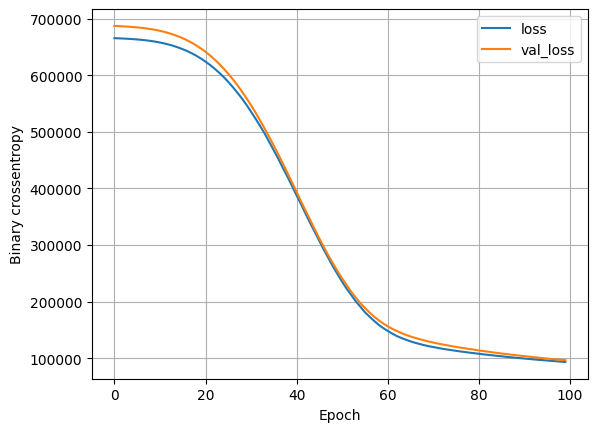

In [ ]:
plot_loss(history)

# Comparing Linear vs Neural Network

In [ ]:
# calculate the MSE for both linear and NN
y_pred_lr = all_reg.predict(X_test_all)
y_pred_nn = nn_model.predict(X_test_all)

def MSE(y_pred, y_real):
  return (np.square(y_pred - y_real)).mean()

print("Linear Regression MSE: ", MSE(y_pred_lr, y_test_all))
print("Neural Network MSE: ", MSE(y_pred_nn, y_test_all))

3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 61ms/step
Linear Regression MSE:  72022.42074411543
Neural Network MSE:  93864.25443655078


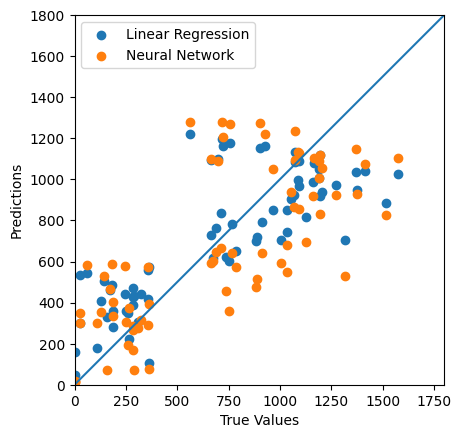

In [ ]:
# Plotting the comparisons
ax = plt.axes(aspect='equal')
plt.scatter(y_test_all, y_pred_lr, label='Linear Regression')
plt.scatter(y_test_all, y_pred_nn, label='Neural Network')
plt.xlabel('True Values')
plt.ylabel('Predictions')
lims = [0,1800]
plt.xlim(lims)
plt.ylim(lims)
_ = plt.plot(lims, lims)
plt.legend()
plt.show()